In [32]:
import pandas as pd
import numpy as np
from random import randint, uniform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [33]:
centroids=pd.DataFrame([(1,1.33,2.5),(2,3.33, 4)], columns=['id','x', 'y'])
centroids

,id,x,y
0,1,1.33,2.5
1,2,3.33,4.0


In [34]:
data=pd.DataFrame([(1,1,1.5),
                   (2,1,4.5),
                   (3,2,1.5),
                   (4,2,3.5),
                   (5,3,2.5),
                   (6,5,6)], columns=['id','x', 'y'])
data

,id,x,y
0,1,1,1.5
1,2,1,4.5
2,3,2,1.5
3,4,2,3.5
4,5,3,2.5
5,6,5,6.0


In [160]:
class Kmeans:
    def __init__(self, k, data):
        self.k=k
        self.initial_data = data.copy()
        
        # initialize k centroids with mock values
        self.initial_centroids=pd.DataFrame(
            np.full((self.k,self.initial_data.shape[1]),-1.0),
            columns=self.initial_data.columns.values)
        self.initial_centroids['id']=np.arange(1,self.k+1)
        
        # assign points to mock clusters
        self.initial_data['k']=-1
        self.initial_data['distance']=-1
        
        self.initial_data.columns += '_d'
        self.initial_centroids.columns += '_c'
        
        
        #create key to allow for join to get cartesian product
        self.initial_data['key']=1
        self.initial_centroids['key']=1
        
        
        self.data=self.initial_data.copy()
        self.centroids = self.initial_centroids.copy()
        
    
    def assign_centroids(self, dataframe, centroids, i):
        #print('\n\nITER: '+str(i)+'\n\nBefore assign: \n', self.data,'\n', self.centroids)
        
        # compute euclidan distance for all combinations
        df_tmp = dataframe.merge(centroids, how='outer')
        df_tmp['distance_d'] = df_tmp.apply(lambda x: np.linalg.norm(
            x[self.data.columns.values.tolist()[1:-3]].values
            -x[self.centroids.columns.values.tolist()[1:-1]].values),axis=1)

        # assign centroid that is closest to the record
        df_tmp=df_tmp.sort_values(['id_d','distance_d']).drop_duplicates(['id_d'],keep='first')
        df_tmp.reset_index(inplace=True)
        df_tmp['k_d']=df_tmp['id_c']
        df_tmp=df_tmp[self.data.columns.values.tolist()].copy()
        return df_tmp
    
    
    def calculate_centroids(self):
        cols=self.centroids.columns
        self.centroids=self.data.drop(['id_d','distance_d'], axis=1).groupby(['k_d']).agg(['mean'])
        self.centroids.reset_index(inplace=True) 
        self.centroids.columns=cols
    
    
    def initialize_clusters(self, method='random'):
        #reset data and centroids
        self.data=self.initial_data.copy()
        self.centroids=self.initial_centroids.copy()
        
        if method == 'random':
            while any(init_k not in self.data['k_d'].values for init_k in range(1,self.k+1)): 
                self.data['k_d']=self.data['k_d'].apply(lambda x: randint(1,self.k))
                #print(self.data)
            #calculate initial centroids       
            self.calculate_centroids()
                
        if method == "d2_weighting":
            tmp_data = self.data.copy()
            for i in range(0,self.k):
                if i == 0:
                # Take one center c1, chosen uniformly at random from X .
                    initial=randint(0,self.k)
                    self.centroids.at[i,'x_c'] = tmp_data.at[initial,'x_d']
                    #print(tmp_data.at[initial,'x_d'], tmp_data.at[initial,'y_d'])
                    self.centroids.at[i,'y_c'] = tmp_data.at[initial,'y_d']        
                    #print(self.centroids)
                    #print(tmp_data)
                    #print('-'*10)
                else:
                # Take a new center ci choosing x ∈ X with probability D(x) / sum x∈X D(x)
                    tmp_data=self.assign_centroids(tmp_data, self.centroids.iloc[:i+1,:], i)
                    
                    #calculate square distance
                    tmp_data['distance_d']=tmp_data['distance_d']**2
                    sum_of_distance=tmp_data['distance_d'].sum()
                    tmp_data['probability']=tmp_data['distance_d']/sum_of_distance
                    
                    #choose  new centroid with propability D(x) / sum  x∈X D(x)
                    select_random=uniform(0,1)
                    cumulant=0
                    for j in range(tmp_data.shape[0]):
                        cumulant = cumulant + tmp_data.at[j, 'probability']
                        if select_random <= cumulant:
                            self.centroids.at[i,'x_c'] = tmp_data.at[j,'x_d']
                            self.centroids.at[i,'y_c'] = tmp_data.at[j,'y_d']
                            break
                    #print(select_random)        
                    #print(self.centroids)
                    #print(tmp_data)
                    #print('-'*10)
            #assign points to nearest centroids created with d2_weighting seeding
            self.data=self.assign_centroids(self.data, self.centroids, i)
        
    def plot_clusters(self, dataframe, centroids, i):

        #select subset of dataframe with features
        X = dataframe.copy().drop(columns=['id_d','k_d','distance_d','key'])
        y = dataframe['k_d'].copy().values
        
        X_c = centroids.copy().drop(columns=['id_c']).values
        y_c = centroids['id_c'].copy().values
        
        if X.shape[1] == 2:
            method = 'Plot'
            X_reduced_pca = X.values
        else:
            method = 'PCA'
            # calculate PCA Implementation of dim reducition
            X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

        #print(X_reduced_pca)
        #print(y)
        #plotting
        f, (ax1) = plt.subplots(1, 1, figsize=(6,6))
        f.suptitle('Iteration ' + str(i), fontsize=14)

        # scatter plot
        ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, cmap='rainbow', linewidths=4)
        ax1.scatter(X_c[:,0], X_c[:,1], c=y_c, marker='x', s=150, cmap='rainbow', linewidths=10)
        ax1.set_title(method, fontsize=14)
        ax1.grid(True)

        plt.show()
        
    
    def Lloyd(self):
        converged=False
        i=0
        while not converged:
            
            
            self.plot_clusters(self.data, self.centroids, i)
            
            i+=1
            #cluster assignments before iteration
            clusters_before = self.data['k_d'].values
            
            #print('\n\nITER: '+str(i)+'\n\nBefore assign: \n', self.data,'\n', self.centroids)
            
            self.data=self.assign_centroids(self.data, self.centroids, i)
            #print('\nAfter assign: \nDane\n', self.data)
            
            #cluster assignments after iteration
            clusters_after = self.data['k_d'].values
            
            #check if algorithm converged
            #print(clusters_before,clusters_after)
            if all(c_before == c_after for c_before, c_after in zip(clusters_before,clusters_after)):
                converged = True
            
            # update centroids
            self.calculate_centroids()
            #print('\nAfter calc centroids: \nCentroidy\n', self.centroids)
            
            #checking if a cluster disapeared in the process (erronous behaviour)
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. Temporary solution.')
                raise Exception
    
    def McQuin(self):
        converged=False
        i=0
        while not converged:
            self.plot_clusters(self.data, self.centroids, i)
            
            i+=1            
            #cluster assignments before iteration
            clusters_before = self.data['k_d'].values
            
            #print('\n\nITER: '+str(i)+'\n\nBefore assign: \n', self.data,'\n', self.centroids)
            
            for index,row in self.data.iterrows():
            
                # turn row of dataframe with updated point into a dataframe
                row = pd.DataFrame(row).T

                # assign centroid to updated point
                self.data.iloc[index,:]=self.assign_centroids(row, self.centroids, i).values[0]
                #print('\nAfter assign: \nDane\n', self.data)
            
                # update centroids
                self.calculate_centroids()
                #print('\nAfter calc cntroids: \nCentroidy\n', self.centroids)
        
            #cluster assignments after iteration
            clusters_after = self.data['k_d'].values
            
            #check if algorithm converged
            #print(clusters_before, clusters_after)
            if all(c_before == c_after for c_before, c_after in zip(clusters_before,clusters_after)):
                converged = True
                
            #checking if a cluster disapeared in the process (erronous behaviour)
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. Temporary solution.')
                raise Exception
    

In [161]:
ex4 = Kmeans(3,data)

In [162]:
ex4.initialize_clusters(method='d2_weighting')

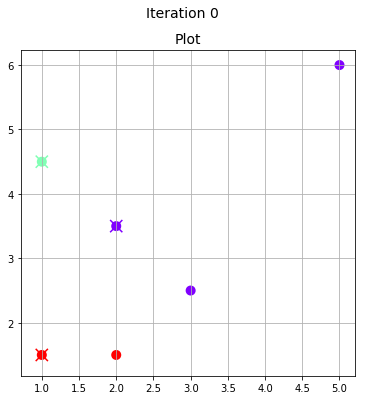

In [163]:
ex4.Lloyd()

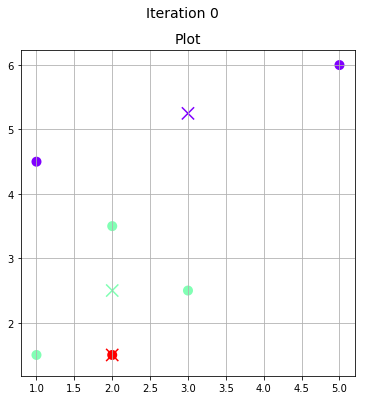

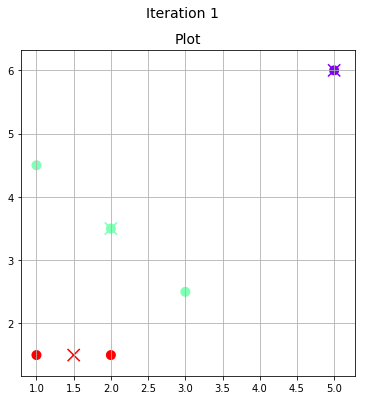

In [164]:
ex4 = Kmeans(3,data)
ex4.initialize_clusters()
ex4.McQuin()